# ATIS Flight Reservations - Information Extraction


<hr>

Table of Contents:

1. Understanding the Data
2. Information Extraction 
    - Pipeline for Information Extraction Systems
    - Named Entity Recognition (NER)
3. Models for Entity Recognition
    - Rule-based models
        - Regular Expression Based Rules (ex)
        - Chunking 
    - Probabilistic models
        - Unigram and Bigram models
        - Naive Bayes Classifier 
        - Conditional Random Fields (CRFs)

<hr>

The ATIS (Airline Travel Information Systems) dataset consists of English language queries for booking (or requesting information about) flights in the US. 

Each word in a query (i.e. a request by a user) is labelled according to its **entity-type**, for e.g. in the query 'please show morning flights from chicago to new york', 'chicago' and 'new york are labelled as 'source' and 'destination' locations respectively while 'morning' is labelled as 'time-of-day' (the exact labelling scheme is a bit different, more on that later).

Some example queries taken from the dataset are shown below:

```
{
'what flights leave atlanta at about DIGIT in the afternoon and arrive in san francisco',
 'what is the abbreviation for canadian airlines international',
 "i 'd like to know the earliest flight from boston to atlanta",
 'show me the us air flights from atlanta to boston',
 'show me the cheapest round trips from dallas to baltimore',
 "i 'd like to see all flights from denver to philadelphia"
 }
 ```

### Objective
Our objective is to **build an information extraction system** which can extract entities relevant for booking flights (such as source and destination cities, time, date, budget constraints etc.) in a **structured format** from a given user-generated query.

A structured format could be a dictionary, a JSON, etc. - basically anything that can be parsed and used for looking up relevant flights from a database.


### Downloads
The dataset is divided into five folds, each fold having a training, validation and test set.
You can download the dataset here: http://lisaweb.iro.umontreal.ca/transfert/lisa/users/mesnilgr/atis/




# Understanding the Data 

Let's understand the structure of the training data. The dataset is provided in five folds, each fold having a training, validation, test set and a dict (explained later). All folds are structurally identical, so understanding one fold is enough to understand the entire set.


In [1]:
# import libaries
import numpy as np
import pandas as pd
import nltk, pprint
import matplotlib.pyplot as plt
import random

import gzip, os, pickle # gzip for reading the gz files, pickle to save/dump trained model 
import _pickle as cPickle

import sklearn
from sklearn.model_selection import GridSearchCV
#from sklearn.grid_search import RandomizedSearchCV
from sklearn.model_selection import RandomizedSearchCV

# supress warnings
import warnings
warnings.filterwarnings('ignore')


Let's now read the first fold of the dataset. The data is in .gz files, so we'll need the gzip library as well. 

In [2]:
# read the first part of the dataset
# each part (.gz file) contains train, validation and test sets, plus a dict

filename = 'Data/atis/atis.fold0.pkl.gz'
f = gzip.open(filename, 'rb')
try:
    train_set, valid_set, test_set, dicts = pickle.load(f, encoding='latin1')
except:
    train_set, valid_set, test_set, dicts = pickle.load(f)
finally:
    f.close()


In [3]:
# type and size of the train set
print(type(train_set))
print()

# types of the three elements in the tuple
print(type(train_set[0]), type(train_set[1]), type(train_set[2]))
print(len(train_set[0]), len(train_set[1]), len(train_set[2]))

<class 'tuple'>

<class 'list'> <class 'list'> <class 'list'>
3983 3983 3983


The training set is a tuple containing three lists of same lengths as shown above. Similarly, the validation and test sets contain three lists as well (shown below).

In [4]:
# validation set
print(type(valid_set[0]), type(valid_set[1]), type(valid_set[2]))
print(len(valid_set[0]), len(valid_set[1]), len(valid_set[2]))
print()

# test set
print(type(test_set[0]), type(test_set[1]), type(test_set[2]))
print(len(test_set[0]), len(test_set[1]), len(test_set[2]))

<class 'list'> <class 'list'> <class 'list'>
995 995 995

<class 'list'> <class 'list'> <class 'list'>
893 893 893


Thus, we have the train, validation and test sets each containing three lists of different lengths. Now, let's understand the data stored in the three lists.

In [5]:
# first few elements in each list of the training set 
pprint.pprint(train_set[0][:3])
print('#'*50)
pprint.pprint(train_set[1][:3])
print('#'*50)
pprint.pprint(train_set[2][:3])

[array([554, 194, 268,  64,  62,  16,   8, 234, 481,  20,  40,  58, 234,
       415, 205]),
 array([554, 241, 481,  14, 200,  91,  26, 239]),
 array([232,   0, 273, 502, 254, 481, 165, 193, 208,  77, 502,  64])]
##################################################
[array([  0,   0,   0,  18,   0,   1,  52,   0,   0,  76,   0,   0,   0,
        18, 109]),
 array([  0,   0,   0,   0,   0,   6, 107, 107]),
 array([ 0,  0,  0,  0,  0,  0, 44,  0,  0, 18,  0, 18])]
##################################################
[array([126, 126, 126,  48, 126,  36,  35, 126, 126,  33, 126, 126, 126,
        78, 123]),
 array([126, 126, 126, 126, 126,   2,  83,  83]),
 array([126, 126, 126, 126, 126, 126,  42, 126, 126,  48, 126,  78])]


The first list contains the actual queries encoded by integers such as 554, 194, 268 ... and so on. For e.g. the first three integers 554, 194, 268 are encoded values of the words 'what', 'flights', 'leave' etc. 


The second list is to be ignored.

The third list contains the (encoded) label of each word (how to do these mappings is explained in detail below). Since the actual words are encoded by numbers, we have to decode them using the dicts provided. Let's first store the three lists into separate objects so we don't have to worry about indexing the lists.


In [6]:
# storing the three elements of the tuple in three objects 
# The '_' is a conventional variable in python used to store non-useful/dummy objects
train_x, _, train_label = train_set
val_x, _, val_label = valid_set
test_x, _, test_label = test_set

So now, for training, validation and test sets, we have the **encoded words and labels** stored in the lists (train_x, train_label), (val_x, val_label) and (test_x, test_label). The first list represents the actual words (encoded), and the other list contains their labels (again, encoded).

Let's now understand the structure of the lists.

In [7]:
# each list in the tuple is a numpy array (which us a complete sentence/query)
# printing first list in the tuple's first element
# each element represents a word of the query
# this translates to 'what flights leave atlanta ....'
train_x[0]

array([554, 194, 268,  64,  62,  16,   8, 234, 481,  20,  40,  58, 234,
       415, 205])

In [8]:
# labels are stored in the third list train_label
train_label[0]

array([126, 126, 126,  48, 126,  36,  35, 126, 126,  33, 126, 126, 126,
        78, 123])

To map the integers to words, we need to use the dictionaries provided. The dicts ```words2idx``` and ```labels2idx``` map the numeric ids to the actual words and labels respectively.

In [9]:
# dicts to map numbers to words/labels
print(type(dicts))
print(dicts.keys())

<class 'dict'>
dict_keys(['labels2idx', 'tables2idx', 'words2idx'])


In [10]:
# each key:value pair is itself a dict
print(type(dicts['labels2idx']))
print(type(dicts['tables2idx']))
print(type(dicts['words2idx']))


<class 'dict'>
<class 'dict'>
<class 'dict'>


In [11]:
# storing labels and words in separate variables
# we'll need only two of these dicts - words and labels
words = dicts['words2idx']
labels = dicts['labels2idx']
tables = dicts['tables2idx']

In [12]:
# each key of 'words' is a word, each value its index
# printing some random key:value pairs of 'words'
random.sample(words.items(), 10)

[('following', 199),
 ('fares', 183),
 ('rate', 395),
 ('restriction', 405),
 ('airline', 25),
 ('us', 532),
 ('washington', 543),
 ('far', 181),
 ('just', 250),
 ('thirty', 490)]

In [13]:
#for k, v in words.items():
#    print(k,v)
#words.keys()

In [14]:
# now, we can map the numeric values v in a sentence with the k,v in the dict
# train_x contains the list of training queries; train_x[0] is the first query
# this is the first query
[k for val in train_x[0] for k,v in words.items() if v==val]

['what',
 'flights',
 'leave',
 'atlanta',
 'at',
 'about',
 'DIGIT',
 'in',
 'the',
 'afternoon',
 'and',
 'arrive',
 'in',
 'san',
 'francisco']

In [15]:
# let's look at the first few queries
sents = []
for i in range(30):
    sents.append(' '.join([k for val in train_x[i] for k,v in words.items() if v==val]))

sents

['what flights leave atlanta at about DIGIT in the afternoon and arrive in san francisco',
 'what is the abbreviation for canadian airlines international',
 "i 'd like to know the earliest flight from boston to atlanta",
 'show me the us air flights from atlanta to boston',
 'show me the cheapest round trips from dallas to baltimore',
 "i 'd like to see all flights from denver to philadelphia",
 'explain fare code qx',
 "i 'd like a united airlines flight on wednesday from san francisco to boston",
 'what is the price of american airlines flight DIGITDIGIT from new york to los angeles',
 'what does the meal code s stand for',
 'what are all flights to denver from philadelphia on sunday',
 'what times does the late afternoon flight leave from washington for denver',
 'what flights are available monday from san francisco to pittsburgh',
 'what airlines have business class',
 'flights from atlanta to washington dc',
 'from new york to toronto on thursday morning',
 'show me all the direct

Similarly, we can map the encoded values of each word's label using the ```labels``` dict.

In [16]:
# labels dict contains IOB (inside-out-beginning) labelled entities
# printing some randomg k:v pairs 
random.sample(labels.items(), 25)

[('I-meal_code', 111),
 ('B-day_number', 23),
 ('B-connect', 20),
 ('B-return_date.date_relative', 59),
 ('I-toloc.airport_name', 122),
 ('I-fromloc.state_name', 110),
 ('B-time_relative', 74),
 ('B-depart_date.month_name', 28),
 ('B-cost_relative', 21),
 ('B-flight_mod', 42),
 ('I-arrive_time.end_time', 86),
 ('I-return_date.day_number', 115),
 ('B-state_name', 68),
 ('I-transport_type', 125),
 ('B-arrive_time.period_mod', 11),
 ('I-depart_time.end_time', 96),
 ('B-class_type', 18),
 ('I-flight_mod', 104),
 ('B-time', 73),
 ('I-flight_stop', 106),
 ('B-airline_name', 2),
 ('B-depart_time.time_relative', 36),
 ('B-aircraft_code', 0),
 ('I-round_trip', 117),
 ('I-depart_date.today_relative', 95)]

There are 127 classes of labels (including the 'O' - tokens that do not fall into any entity).

In [17]:
# number of labels
print(len(labels.keys()))

127


#### Reversing the Dictionaries

Since the dicts ```words``` and ```labels``` are key:value pairs of index:word/label, let's reverse the dicts so that we don't have to do a reverse lookup everytime.

In [18]:
# converting words_to_id to id_to_words
# and labels_to_id to id_to_labels
id_to_words = {words[k]:k for k in words}
id_to_labels = {labels[k]:k for k in labels}

Now we can print the words and corresponding labels simply by looking up the value of a numeric index of each word. Let's write a function which takes in an index and returns the corresponding query with its labels.

In [19]:
# takes in an integer index corresponding to a query 
# and returns a list of (word, label) pairs   
def print_query(index):
    w = [id_to_words[id] for id in train_x[index]]
    l = [id_to_labels[id] for id in train_label[index]]
    return list(zip(w, l))

In [20]:
# sample query
print_query(3900)

[('please', 'O'),
 ('show', 'O'),
 ('me', 'O'),
 ('the', 'O'),
 ('return', 'O'),
 ('flight', 'O'),
 ('number', 'O'),
 ('from', 'O'),
 ('toronto', 'B-fromloc.city_name'),
 ('to', 'O'),
 ('st.', 'B-toloc.city_name'),
 ('petersburg', 'I-toloc.city_name')]

Also, some queries specify stopover cities, such as this.

In [21]:
# example query: stopover city
print_query(3443)

[('is', 'O'),
 ('there', 'O'),
 ('a', 'O'),
 ('flight', 'O'),
 ('between', 'O'),
 ('oakland', 'B-fromloc.city_name'),
 ('and', 'O'),
 ('boston', 'B-toloc.city_name'),
 ('with', 'O'),
 ('a', 'O'),
 ('stopover', 'O'),
 ('in', 'O'),
 ('dallas', 'B-stoploc.city_name'),
 ('fort', 'I-stoploc.city_name'),
 ('worth', 'I-stoploc.city_name'),
 ('on', 'O'),
 ('twa', 'B-airline_code')]

# Information Extraction 

**Information Extraction (IE)** refers to the task of extracting structured information from unstructured text data. In this case, we want to extract all pieces of information from a query which are useful in making a flight reservation, such as source and destination cities, date of travel, price range etc. 

Other examples of IE tasks are extracting information about stock market announcements from financial news (which could be useful for predicting stock prices etc.), extracting structured information from large corpora of documents such as encyclopedias, government documents etc. On wikipedia, for e.g., some structured information is shown on the right side of the pages:


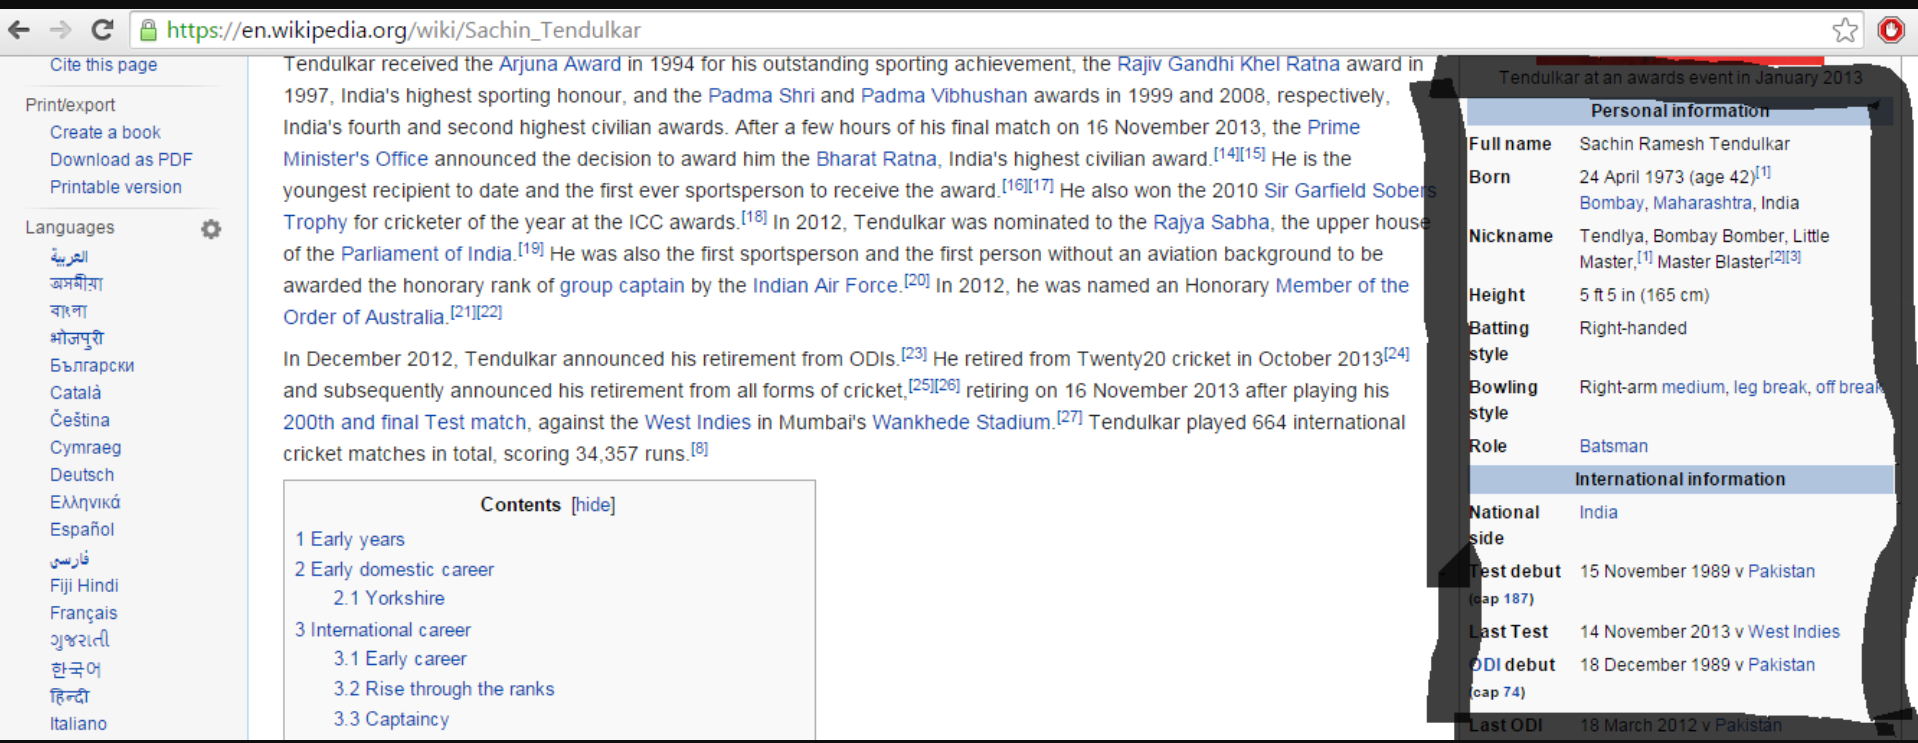

Most IE tasks start with the task of **Named Entity Recognition (NER)** - identifying mentions of *entities* in the text. Loosely speaking, entities refer to names of people, organizations (e.g. Air India, United Airlines), places/cities (Mumbai, Chicago), dates and timepoints (May, Wednesday, morning flight), numbers of specific types (e.g. money - 5000 INR) etc.

The general process of information extraction is described below.



## Information Extraction Pipeline

Most IE pipelines start with the usual text preprocessing steps - sentence segmentation, word tokenisation and POS tagging. After preprocessing, the usual tasks are named entity recognition, and optionally relation recognition. 

Note that this is a generic pipeline, and you may make modifications according to the nature of your application. For example, you may add a 'spell check/correction layer' as the first preprocessing step if you expect some input data to have spelling errors.

A generic IE pipeline schema, taken from the official NLTK book, is shown below.

<br><br><hr>
<img src='https://www.nltk.org/images/ie-architecture.png'>
<br><br><hr>

### Preprocessing 

The usual preprocessing steps are - if the raw input data is in the form of paragraphs, it is converted into sentences using a **sentence segmenter**, then broken down into tokens using **tokenisation**, and finally each token is **POS tagged**.



### Named Entity Recognition (NER)

The labels corresponding to each word/token, as shown above, are of three types - I, O and B, which stand for inside, out and beginning (called **IOB tags**). This is a common way of labelling text data meant for NER tasks. The task of information extraction and named-entity recognition is explained in detail below. First, let's understand the task of NER and IOB labelling in detail.

Some example IOB tagged words are shown below:


In [22]:
# run multiple times to see samples
# randomly chosen sample IOB tagged queries from training data
i=random.randrange(len(train_x))
print_query(i)

[('okay', 'O'),
 ('i', 'O'),
 ("'d", 'O'),
 ('like', 'O'),
 ('to', 'O'),
 ('fly', 'O'),
 ('from', 'O'),
 ('denver', 'B-fromloc.city_name'),
 ('to', 'O'),
 ('pittsburgh', 'B-toloc.city_name')]

In the query above, there are two named entities (cities) - san francisco and denver. 

Since san francisco comprises of two words, the first one is tagged *B-* and the second as *I-*. On the other hand, denver is only one word, so there's no *I-* tag. All the other words are not entities and are thus marked *O* (outside any entity).

The **NER task** is to **predict the IOB labels** of each word.

### NER as a Sequence-Labelling Task

The task of **training an NER system**, i.e. assigning an IOB label to each word, is a **sequence labelling task** similar to POS tagging. For sequence labelling, one can try rule-based models such as writing **regular-expression based rules** to extract entities, **chunking** patterns of POS tags into an 'entity chunk' etc. (we'll try some of these below)

One the other hand, one can use **probabilistic sequence labelling models** such as **HMMs**, the **Naive Bayes** classifier (classifying each word into one label class), **Conditional Random Fields (CRFs)** etc. 

Once the IOB tags of each word are predicted, we can **evaluate the model** using the usual metrics for multi-class classification models (num_classes = number of IOB tags).

In the upcoming sections, we will try some of these approaches and compare their performance.

# Models for Entity Recognition

In the following sections, we'll build a variety of models for entity recognition, i.e. to predict the sequence of IOB tag of words. We'll try the two broad approaches - **rule-based models** and **probabilistic models**. 

Before that, we need to do some basic preprocessing of the data. 

## Part of Speech Tagging

The usual preprocessing steps are sentence segmentation, tokenisation and POS tagging, but since in this case the raw data is already split into sentences (queries) and words, we only need to do POS tagging.

The function below takes in a list of (encoded) sentences, uses the dict ```id_to_words``` to decode the numeric to the corresponding word, and returns the POS tagged list of sentences.

In [28]:
# POS tagging sentences
# takes in a list of sentences and returns a list of POS-tagged sentences
# in the form (word, tag)

def pos_tag(sent_list):
    pos_tags = []    
    for sent in sent_list:
        tagged_words = nltk.pos_tag([id_to_words[val] for val in sent])
        pos_tags.append(tagged_words)
    return pos_tags

In [29]:
# pos tagging train, validation and test sets
train_pos = pos_tag(train_x)
valid_pos = pos_tag(val_x)
test_pos = pos_tag(test_x)

In [30]:
# looking at tags of some randomly chosen queries
# notice that most cities after 'TO' are incorrectly tagged as VB
i = random.randrange(len(train_pos))
train_pos[i]

[('show', 'NN'),
 ('flights', 'NNS'),
 ('from', 'IN'),
 ('denver', 'NN'),
 ('into', 'IN'),
 ('san', 'JJ'),
 ('francisco', 'NN')]

**Problems with the NLTK Tagger**

Note that almost all city/airport names that come after 'to/TO' are tagges as verbs 'VB', which is clearly incorrect. This is because NLTK's built-in tagger is trained using the penntreebank dataset, and it takes 'to/TO' as a strong signal for a 'VB'.


In general, the performance of a POS tagger depends a lot on the data used to train it. There are alternatives to it - one, you can try using an alternative tagger such as the Stanford tagger, Spacy etc. (though note that getting them up and running in python may take a bit of time in installing dependencies/debugging etc.).

The other alternative (recommended as a quick fix) is to use a **backup tagger** within NLTK, i.e. manually specify a unigram/bigram tagger to be used, and backed up by the standard NLTK tagger. You can <a href="https://stackoverflow.com/questions/5919355/custom-tagging-with-nltk/5922373#5922373">learn how to do that here.</a>


### Creating 3-tuples of ```(word, pos, IOS_label)```
To train a model, we need the entity labels of each word along with the POS tags, for e.g. in this format:

```
('show', 'VB', 'O'),
('me', 'PRP', 'O'),
('the', 'DT', 'O'),
('cheapest', 'JJS', 'B-cost_relative'),
('round', 'NN', 'B-round_trip'),
('trips', 'NNS', 'I-round_trip'),
('from', 'IN', 'O'),
('dallas', 'NN', 'B-fromloc.city_name'),
('to', 'TO', 'O'),
('baltimore', 'VB', 'B-toloc.city_name')
```
<hr>

Let's convert the training, validation and test sentences to this form. Since we have already  done POS tagging of the queries, we'll write a function which takes queries in the form (word, pos_tag) and the labels as input, and returns the list of sentences in the form (word, pos_tag, iob_label).

In [31]:
# function to create (word, pos_tag, iob_label) tuples for a given dataset
def create_word_pos_label(pos_tagged_data, labels):
    iob_labels = []         # initialize the list of 3-tuples to be returned
    
    for sent in list(zip(pos_tagged_data, labels)):
        pos = sent[0]       
        labels = sent[1]    
        zipped_list = list(zip(pos, labels)) # [(word, pos), label]
        
        # create (word, pos, label) tuples from zipped list
        tuple_3 = [(word_pos_tuple[0], word_pos_tuple[1], id_to_labels[label]) 
                   for word_pos_tuple, label in zipped_list]
        iob_labels.append(tuple_3)
    return iob_labels

In [32]:
# printing some sample queries in the form (word, pos, label)
train_labels = create_word_pos_label(train_pos, train_label)
train_labels[4:6]

[[('show', 'VB', 'O'),
  ('me', 'PRP', 'O'),
  ('the', 'DT', 'O'),
  ('cheapest', 'JJS', 'B-cost_relative'),
  ('round', 'NN', 'B-round_trip'),
  ('trips', 'NNS', 'I-round_trip'),
  ('from', 'IN', 'O'),
  ('dallas', 'NN', 'B-fromloc.city_name'),
  ('to', 'TO', 'O'),
  ('baltimore', 'VB', 'B-toloc.city_name')],
 [('i', 'JJ', 'O'),
  ("'d", 'MD', 'O'),
  ('like', 'VB', 'O'),
  ('to', 'TO', 'O'),
  ('see', 'VB', 'O'),
  ('all', 'DT', 'O'),
  ('flights', 'NNS', 'O'),
  ('from', 'IN', 'O'),
  ('denver', 'NN', 'B-fromloc.city_name'),
  ('to', 'TO', 'O'),
  ('philadelphia', 'VB', 'B-toloc.city_name')]]

In [33]:
# storing validation and test data as well as (word, pos, label)
valid_labels = create_word_pos_label(valid_pos, val_label)
test_labels = create_word_pos_label(test_pos, test_label)

Now that we have converted the queries in the form (word, pos, label), we can convert them into a **tree format** and observe the actual entities more clearly (rather than IOB labels). 

In general, IOB tagged sentences are represented in either of the two common formats - 1. The ```(word, pos, label)``` or the tagged list format or 2. The tree format. 

As we will see later, some built-in models/sequence taggers in NLTK need the data in the tree format.

### Converting List to Tree Format

Let's now convert the sentences into a tree format, which is needed by NLTK to train taggers. In NLTK, there are two main methods to convert between the two formats (the list of tags and tree) - ```conlltags2tree``` and ```tree2conlltags```.

In [34]:
from nltk.corpus import conll2000
from nltk import conlltags2tree, tree2conlltags

# print a sample tree in tuple format
train_labels[3]

[('show', 'VB', 'O'),
 ('me', 'PRP', 'O'),
 ('the', 'DT', 'O'),
 ('us', 'PRP', 'B-airline_name'),
 ('air', 'NN', 'I-airline_name'),
 ('flights', 'NNS', 'O'),
 ('from', 'IN', 'O'),
 ('atlanta', 'NN', 'B-fromloc.city_name'),
 ('to', 'TO', 'O'),
 ('boston', 'VB', 'B-toloc.city_name')]

In [36]:
# converting the sample sentence above to tree format
tree = conlltags2tree(train_labels[3])
print(tree)

(S
  show/VB
  me/PRP
  the/DT
  (airline_name us/PRP air/NN)
  flights/NNS
  from/IN
  (fromloc.city_name atlanta/NN)
  to/TO
  (toloc.city_name boston/VB))


The tree above shows three entities in the query - ```flight_mod earliest``` (earliest), ```fromloc.city_name``` (boston), ```toloc.city_name``` (atlanta).

Let's now convert all training sentences to trees.

In [37]:
# converting training, validation and test datasets to tree format
train_trees = [conlltags2tree(sent) for sent in train_labels]
valid_trees = [conlltags2tree(sent) for sent in valid_labels]
test_trees = [conlltags2tree(sent) for sent in test_labels]

In [39]:
# print some sample training trees
i=random.randrange(len(train_trees))
print(train_trees[i])

(S
  flights/NNS
  from/IN
  (fromloc.city_name ontario/NN)
  to/TO
  (toloc.state_name florida/VB))


Now that we have the queries in tree formats, we can build some models to extract entities.

## Rule-Based Models for Entity Recognition

The most basic rule-based system can be written using regular expressions. The idea is to manually identify patterns which indicate occurence of entities we are interested in, such as source and destination cities, mentions of dates and time, names of organisations (in this case airlines such as united airlines, american airlines etc.) and write regular expressions to match them.


### Chunking

Chunking is a way to identify meaningful sequences of tokens called chunks in a sentence. It is commonly used to identify sequences of nouns, verbs etc. For example, in the example sentence taken from the NLTK book: <br>

S = *"We saw the yellow dog"*

there are two **noun phrase chunks** as shown below. Each outer box represents a chunk.

<img src='https://www.nltk.org/book/tree_images/ch07-tree-1.png'>

The corresponding **IOB representation** of the same is as follows:

<img src='https://www.nltk.org/images/chunk-tagrep.png'>



Similarly, in our dataset, the following sentence contains chunks such as fromloc.city_name (san francisco), class_type (first class), depart_time.time (DIGITDIGIT noon) etc.


In [51]:
# sample chunks 
print(train_trees[3468])

(S
  show/VB
  me/PRP
  flights/NNS
  on/IN
  (depart_date.day_name sunday/NN)
  going/VBG
  from/IN
  (fromloc.city_name san/JJ francisco/NN)
  to/TO
  (toloc.city_name boston/VB)
  (flight_stop nonstop/JJ)
  (class_type first/JJ class/NN)
  leaving/NN
  (depart_time.time_relative after/IN)
  (depart_time.time DIGITDIGIT/NNP noon/NN))


There are various techniques for building chunkers, such as regex based, unigram and bigram chunkers etc.

### Regular Expression Based Chunkers

Regex based chunkers define what is called a **chunk grammar**. A **chunk grammar is a pattern of POS tags** which are likely to form a particular chunk (and thus POS tagging is a necessary preprocessing step for such chunkers). 

The example from the NLTK book defined a simple garmmar to identify noun phrase chunks:



In [52]:
# chunking example sentence
sentence = [("the", "DT"), ("little", "JJ"), ("yellow", "JJ"),
            ("dog", "NN"), ("barked", "VBD"), ("at", "IN"), ("the", "DT"), ("cat", "NN")]

Now, we **define a chunk grammar** to identify noun phrase chunks as follows: *A noun phrase chunk occurs when an optional determiner (DT) is followed by any number of adjectives (JJ) and then a noun (NN).*

In [53]:
# define chunk grammar to identify noun phrase chunks
# an optional determiner (DT), followed by any number of adjectives (JJ) 
# and then a noun (NN)
grammar = "NP_chunk: {<DT>?<JJ>*<NN>}"

We now use the ```nltk.RegexpParser``` to parse the given sentence. The output will be a tree which identifies the NP chunks.

In [54]:
# parse the sentence
cp = nltk.RegexpParser(grammar)
result = cp.parse(sentence)
print(result)

(S
  (NP_chunk the/DT little/JJ yellow/JJ dog/NN)
  barked/VBD
  at/IN
  (NP_chunk the/DT cat/NN))


The first NP chunk is 'the little yellow dog' and the second one is 'the cat'. One can also print the list representation of this tree as follows:

In [55]:
# list form of the tree
tree2conlltags(result)

[('the', 'DT', 'B-NP_chunk'),
 ('little', 'JJ', 'I-NP_chunk'),
 ('yellow', 'JJ', 'I-NP_chunk'),
 ('dog', 'NN', 'I-NP_chunk'),
 ('barked', 'VBD', 'O'),
 ('at', 'IN', 'O'),
 ('the', 'DT', 'B-NP_chunk'),
 ('cat', 'NN', 'I-NP_chunk')]

Similarly, we can write rules to identify entities in the airlines dataset. Before building any useful chunkers, let's first make a **baseline chunker** - one which assigns the label 'O' to every word and see its evaluation metrics. We can then compare the eventual models with this one. 

In [56]:
# baseline (dummy chunker)
# assigns 'O' to each word

grammar = ''

# initialise cp 
cp = nltk.RegexpParser(grammar)

# evaluate results against actual IOB labels
result = cp.evaluate(train_trees)
print(result)

ChunkParse score:
    IOB Accuracy:  63.8%%
    Precision:      0.0%%
    Recall:         0.0%%
    F-Measure:      0.0%%


An accuracy of 63.8% shows that about 63% words have the tag 'O', i.e. they do not fall in any chunk/entity. The other metrics are 0 since we did not predict any chunks at all.

Let's now look at a few sentences and try to identify patterns for the chunks ```fromloc.city_name``` and ```toloc.city_name``` (since these are the most common entities).

In [57]:
# sample queries 
print(train_trees[random.randrange(len(train_trees))])

(S
  i/NN
  would/MD
  like/VB
  one/CD
  flight/NN
  from/IN
  (fromloc.city_name kansas/JJ city/NN)
  to/TO
  (toloc.city_name st./VB paul/NN)
  arriving/VBG
  (arrive_time.time_relative around/IN)
  (arrive_time.period_of_day dinnertime/JJ)
  DIGIT/NNP
  pm/NN)


It is easy to see that a common pattern is *from city_1 to city_2*. The POS tag of from is 'IN', to is 'TO'. However, there's an interesting flaw in the tagger - most cities (city_2) after TO are tagged as as verb 'VB' (the nltk tagger uses 'TO' as a string signal for a verb).

Nevertheless, the pattern is ```from/IN city_1/JJ city_1/NN to/TO city_2/VB city_2/NN``` (you can try looking at multiple sentences and verify).

Let's define the grammar to identify the two types of chunks - ```fromloc.city_name``` and ```toloc.city_name```. The syntax is to simply write two regexes within the grammar, one for each, one after the other.

In [58]:
# grammar for source and destination city chunks
grammar = '''
fromloc.city_name: {<JJ>?<NN>}
toloc.city_name: {<VB><NN>?}
'''
cp = nltk.RegexpParser(grammar)
result = cp.evaluate(train_trees)
print(result)

ChunkParse score:
    IOB Accuracy:  65.2%%
    Precision:     31.7%%
    Recall:        40.9%%
    F-Measure:     35.7%%


The results are although better than the baseline model, they are still quite unimpressive. Notice that now precision, recall and f-score are non-zero, indicating that the chunker is able to identify at least some chunks correctly (in this case ```fromloc.city_name``` and ```toloc.city_name```).

We can add more regex patterns for other chunk types as well.

We can see that in this dataset, queries are quite complex (large variety of labels, sentence structures etc.) and thus it is extremely hard write hand-written rules to extract useful entities.

Thus, we need to train probabilistic models such as CRFs, HMMs etc. to tag each word with its corresponding entity label.


## Probabilistic Models for Entity Recognition

Let's experiment with a few different models for labelling words with named entities.


### Unigram Chunker

Let's now try a **unigram chunker**. A unigram chunker assigns the IOB label that is most likely for each POS tag.

The following code defines a class ```UnigramChunker``` which (on initialisation) first converts the tree form of a sentence to the list form (word, pos, label), extracts the (pos, label) pairs and computes the unigram probabilities ```P(label | pos)``` for each POS tag. It then simply assigns the label that is most likely for the POS tag.

The ```parse()``` method of the class takes a sentence in the form (word, pos) as the input, extracts only the pos tag from it, and uses the unigram tagger to assign the IOB label to each word. It then returns the sentence after converting it to a tree format.

Note that the unigram tagger, like the previous regex-based chunkers, *does not make use of the word itself but only the word's POS tag*.

In [59]:
# unigram chunker

from nltk import ChunkParserI

class UnigramChunker(ChunkParserI):    
    def __init__(self, train_sents):
        # convert train sents from tree format to tags
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] 
                      for sent in train_sents]
        self.tagger = nltk.UnigramTagger(train_data)
        
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        
        # convert to tree again
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [60]:
# unigram chunker 
unigram_chunker = UnigramChunker(train_trees)
print(unigram_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  66.3%%
    Precision:     37.5%%
    Recall:        18.5%%
    F-Measure:     24.8%%


The accuracy, precision and recall have slightly improved compared to the previous regex-based  parser. 

Let's also look at what the unigram parser has learnt.

In [61]:
# printing the most likely IOB tags for each POS tag

# extract the list of pos tags
postags = sorted(set([pos for sent in train_trees for (word, pos) in sent.leaves()]))

# for each tag, assign the most likely IOB label
print(unigram_chunker.tagger.tag(postags))

[('CC', 'O'), ('CD', 'B-round_trip'), ('DT', 'O'), ('EX', 'O'), ('FW', 'B-fromloc.city_name'), ('IN', 'O'), ('JJ', 'O'), ('JJR', 'B-cost_relative'), ('JJS', 'B-cost_relative'), ('MD', 'O'), ('NN', 'O'), ('NNP', 'B-depart_time.time'), ('NNS', 'O'), ('PDT', 'O'), ('POS', 'O'), ('PRP', 'O'), ('PRP$', 'O'), ('RB', 'O'), ('RBR', 'B-cost_relative'), ('RBS', 'B-cost_relative'), ('RP', 'O'), ('TO', 'O'), ('VB', 'B-toloc.city_name'), ('VBD', 'O'), ('VBG', 'O'), ('VBN', 'O'), ('VBP', 'O'), ('VBZ', 'O'), ('WDT', 'O'), ('WP', 'O'), ('WRB', 'O')]


The unigram tagger has learnt that most pos tags are indeed an 'O', i.e. don't form an entity. Some interesting patterns it has learnt are:
- JJR, JJS (relative adjectives), are most likely B-cost_relative (e.g. cheapest, cheaper)
- NNP is most likely to be B-depart_time.time

### Bigram Chunker

Let's try a bigram chunker as well - we just need to change the ```UnigramTagger``` to ```BigramTagger```. This works exactly like the unigram chunker, the only difference being that now the probability of a pos tag having a label is computed using the current and the previous POS tags, i.e. P(label | pos, prev_pos).

In [62]:
# bigram tagger

class BigramChunker(ChunkParserI):    
    def __init__(self, train_sents):
        # convert train sents from tree format to tags
        train_data = [[(t, c) for w, t, c in nltk.chunk.tree2conlltags(sent)] 
                      for sent in train_sents]
        self.tagger = nltk.BigramTagger(train_data)
        
    def parse(self, sentence):
        pos_tags = [pos for (word, pos) in sentence]
        tagged_pos_tags = self.tagger.tag(pos_tags)
        chunktags = [chunktag for (pos, chunktag) in tagged_pos_tags]
        
        # convert to tree again
        conlltags = [(word, pos, chunktag) for ((word, pos), chunktag) in zip(sentence, chunktags)]
        return nltk.chunk.conlltags2tree(conlltags)
        

In [63]:
# unigram chunker 
bigram_chunker = BigramChunker(train_trees)
print(bigram_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  70.6%%
    Precision:     43.5%%
    Recall:        38.8%%
    F-Measure:     41.0%%


The metrics have improved significantly from unigram to bigram, which is expected. However, there are still some major flaws in this approach to build chunkers, the main drawback being that the model *uses only the POS tag to assign the label, not the actual word itself*. 

It is likely that if a model can make use of the word itself apart from the POS tag, it should be able to learn more complex patterns needed for this task. 

In fact, apart from the word, we can extract a large number of other features, such as previous word, previous tag, whether the word is a numeric, whether the word is a city or an airline company etc.

Thus, in the following few sections, we'll extract a variety of features and build classifiers such as Naive Bayes using those features. 

Our first step in the direction of feature extraction will be to extract an feature which indicates whether a word is a city, state or county etc. Such features can be extracted by simply **looking up a gazetteer**.


### Using a Gazetteer to Lookup Cities and States

A gazetteer is a geographical directory which stores data regarding the names of geographical entities (cities, states, countries) and some other features related to the geographies. An example gazetteer file for the US is given below.

Data download URL: https://raw.githubusercontent.com/grammakov/USA-cities-and-states/master/us_cities_states_counties.csv


We'll write a simple function which takes a word as input and returns a tuple indicating **whether the word is a city, state or a county**.

In [64]:
# reading a file containing list of US cities, states and counties
us_cities = pd.read_csv("Data/us_cities_states_counties.csv", sep="|")
us_cities.head()


,City,State short,State full,County,City alias
0,Holtsville,NY,New York,SUFFOLK,Internal Revenue Service
1,Holtsville,NY,New York,SUFFOLK,Holtsville
2,Adjuntas,PR,Puerto Rico,ADJUNTAS,URB San Joaquin
3,Adjuntas,PR,Puerto Rico,ADJUNTAS,Jard De Adjuntas
4,Adjuntas,PR,Puerto Rico,ADJUNTAS,Colinas Del Gigante


In [65]:
# storing cities, states and counties as sets
cities = set(us_cities['City'].str.lower())
states = set(us_cities['State full'].str.lower())
counties = set(us_cities['County'].str.lower())

In [66]:
print(len(cities))
print(len(states))
print(len(counties))

18854
62
1932


In [67]:
# define a function to look up a given word in cities, states, county
def gazetteer_lookup(word):
    return (word in cities, word in states, word in counties)

In [68]:
# sample lookups
print(gazetteer_lookup('washington'))
print(gazetteer_lookup('utah'))
print(gazetteer_lookup('philadelphia'))


(True, True, True)
(False, True, True)
(True, False, True)


Now let's build some **classifiers for NER**, i.e. classification models which take in each word (i.e. its features) as input and predicts its IOB label.

## Classifiers for NER 

As discussed above, IOB tagging is a **sequence classification task** - given a sequence of words and pos tags, predict the IOB label of the word. 

One of the main advantages of classifier based chunkers is that we can use a variety of features which we think will be strong indicators of a word's IOB tag. 

For e.g. if a word is a state/city name such as 'boston', it is very likely an ```B-fromloc.city_name``` or ```B-toloc.city_name```. 

Similarly, we can expect that the **previous word and the previous POS tag** could help predict the IOB labels of a word; that **if a word is the first or the last in the sentence** may strongly help predict the IOB label, etc. 

Also, in all sequence classification tasks, one can use the **predicted labels of the previous words** as features (recall that HMMs compute transition probabilities).


The following code implements the Naive Bayes classifer which uses a variety of **word features** for classification. 

The function ```npchunk_features()```  takes in a sentence and  the word whose features are to be extracted (defined by its index i in the sentence) as input and returns a dictionary of word features as output. It also takes a ```history``` argument - a list of already predicted previous tags to the left of the target word, which is useful if you are using them as features.



In [69]:
# extracts features for the word at index i in a sentence 
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    
    # the first word has both previous word and previous tag undefined
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]

    # gazetteer lookup features (see section below)
    gazetteer = gazetteer_lookup(word)

    return {"pos": pos, "prevpos": prevpos, 'word':word,
           'word_is_city': gazetteer[0],
           'word_is_state': gazetteer[1],
           'word_is_county': gazetteer[2]}

Let's now look at word features of some example sentences.

In [70]:
# example sentence
sent_pos = train_pos[0]
sent_pos

[('what', 'WP'),
 ('flights', 'NNS'),
 ('leave', 'VBP'),
 ('atlanta', 'VBN'),
 ('at', 'IN'),
 ('about', 'RB'),
 ('DIGIT', 'NNP'),
 ('in', 'IN'),
 ('the', 'DT'),
 ('afternoon', 'NN'),
 ('and', 'CC'),
 ('arrive', 'NN'),
 ('in', 'IN'),
 ('san', 'JJ'),
 ('francisco', 'NN')]

In [71]:
# features for sentence sent_pos
# each word's features are stored in a dict
for i in range(len(sent_pos)):
    print(npchunk_features(sent_pos, i, history=[]))
    print(' ')

{'pos': 'WP', 'prevpos': '<START>', 'word': 'what', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'NNS', 'prevpos': 'WP', 'word': 'flights', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'VBP', 'prevpos': 'NNS', 'word': 'leave', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'VBN', 'prevpos': 'VBP', 'word': 'atlanta', 'word_is_city': True, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'IN', 'prevpos': 'VBN', 'word': 'at', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'RB', 'prevpos': 'IN', 'word': 'about', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'NNP', 'prevpos': 'RB', 'word': 'DIGIT', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'IN', 'prevpos': 'NNP', 'word': 'in', 'word_is_city': False, 'word_is_state': False, 'word_is_county': False}
 
{'pos': 'DT', '

Now, we define two classes ```ConsecutiveNPChunkTagger``` and ```ConsecutiveNPChunker```.

The ```__init__``` method of the ```ConsecutiveNPChunkTagger``` class creates the ```train_set``` which is a list of labelled training sentences. Each sentence is a list of tuples (featureset, tag) -  each tuple is the featureset (dict) of a word and its label. 

The list ```history``` contains the list of previously predicted IOB tags, i.e. tags to the left of the target word. We can only use IOB tags to the left of the target word since that's all the tags we have at the time of prediction.

The ```__init__``` method takes in an IOB tagged list of train_sents and loops through them. It first untags the IOB tags to generate (word, pos_tag) tuples stored in ```untagged_sent```. These tuples are used to compute the word features.

Then for each (word, IOB_tag) in ```tagged_sent```, it computes the word features and appends the feature dict and the tag to ```train_sents```. It further appends the IOB tag to ```history```.
 
The ```tag()``` method simply takes in a sentence as a list of words and predicts the IOB label of each word in the sentence.

The ```ConsecutiveNPChunker``` class does all the the uninteresting work of converting between tree-list-tree formats (since NLTK's builtin classifiers need the list format). It takes in a list of sentences as trees, converts each sentence to the list form, and then initialises its tagger using methods already defined in the ```ConsecutiveNPChunkTagger``` class. The ```parse``` method tags the sentence and returns it in the tree format since it is easier to print and read.



In [72]:
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            # compute features for each word
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.NaiveBayesClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [73]:
# training the chunker 
chunker = ConsecutiveNPChunker(train_trees)

In [74]:
# evaluate the chunker
print(chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  91.7%%
    Precision:     75.3%%
    Recall:        81.8%%
    F-Measure:     78.4%%


The results have improved significantly compared to the basic unigram/bigram chunkers, and they may improve further if we create better features.

For example, if the word is 'DIGIT' (numbers are labelled as 'DIGIT' in this dataset), we can have a feature which indicates that (see example below). In this dataset, 4-digit numbers are encoded as 'DIGITDIGITDIGITDIGIT'.

In [75]:
# example of 'DIGITDIGITDIGIT'
train_pos[1326]

[('do', 'VBP'),
 ('you', 'PRP'),
 ('have', 'VB'),
 ('an', 'DT'),
 ('DIGITDIGITDIGIT', 'NNP'),
 ('flight', 'NN'),
 ('from', 'IN'),
 ('denver', 'NN'),
 ('to', 'TO'),
 ('san', 'VB'),
 ('francisco', 'NN')]

Let's add some of these features and see if the performance improves.

In [76]:
# extracts features for a given word i in a given sentence 
# history refers to the previous POS tags in the sentence
def npchunk_features(sentence, i, history):
    word, pos = sentence[i]
    
    # the first word has both previous word and previous tag undefined
    if i == 0:
        prevword, prevpos = "<START>", "<START>"
    else:
        prevword, prevpos = sentence[i-1]
        
    if i == len(sentence)-1:
        nextword, nextpos = '<END>', '<END>'
    else:
        nextword, nextpos = sentence[i+1]

    # gazetteer lookup features (see section below)
    gazetteer = gazetteer_lookup(word)

    # adding word_is_digit feature (boolean)
    return {"pos": pos, "prevpos": prevpos, 'word':word, 
           'word_is_city': gazetteer[0],
           'word_is_state': gazetteer[1],
           'word_is_county': gazetteer[2],
           'word_is_digit': word in 'DIGITDIGITDIGIT', 
           'nextword': nextword, 
           'nextpos': nextpos}

In [77]:
# train and evaluate the chunker 
chunker = ConsecutiveNPChunker(train_trees)
print(chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  91.7%%
    Precision:     75.9%%
    Recall:        85.1%%
    F-Measure:     80.3%%


We can also see the most informative features of the NLTK NB classifier.

In [78]:
# most top-N informative features
chunker.tagger.classifier.show_most_informative_features(15)

Most Informative Features
                     pos = 'JJS'          B-cost : O      =  14237.4 : 1.0
                    word = 'after'        B-depa : O      =   5457.6 : 1.0
           word_is_digit = True           B-depa : O      =   5138.3 : 1.0
                    word = 'pm'           I-depa : O      =   4549.1 : 1.0
                    word = 'DIGIT'        B-depa : O      =   3148.4 : 1.0
                    word = 'expensive'    I-cost : O      =   2635.1 : 1.0
                    word = 'DIGITDIGITDIGIT' B-flig : O      =   2320.5 : 1.0
                     pos = 'JJR'          B-cost : O      =   2217.6 : 1.0
                 prevpos = 'NNP'          I-depa : B-tolo =   1967.9 : 1.0
                     pos = 'NNP'          B-depa : O      =   1841.4 : 1.0
                    word = 'DIGITDIGITDIGITDIGIT' B-fare : O      =   1840.8 : 1.0
                nextword = 'expensive'    B-cost : O      =   1567.3 : 1.0
                nextword = 'pm'           B-depa : O      =   1

We can see that some informative features are ```pos```, ```word```, ```word_is_digit``` etc.

When pos=JJS (superlative adjective e.g. *"cheapest"*), the ratio of probability of the labels ```B-cost:O``` is about 14237:1. Similarly, the features ```word``` and ```word_is_digit``` are very strong indicators of the labels ```B-depa``` and ```I-depa``` (departure time e.g. *"after DIGIT pm"*).

We can also try other classifiers that come with NLTK - let's try building a **decision tree**.

In [79]:
# Decision Tree Classifier
class ConsecutiveNPChunkTagger(nltk.TaggerI): 

    def __init__(self, train_sents):
        train_set = []
        for tagged_sent in train_sents:
            untagged_sent = nltk.tag.untag(tagged_sent)
            history = []
            # compute features for each word
            for i, (word, tag) in enumerate(tagged_sent):
                featureset = npchunk_features(untagged_sent, i, history) 
                train_set.append( (featureset, tag) )
                history.append(tag)
        self.classifier = nltk.DecisionTreeClassifier.train(train_set)

    def tag(self, sentence):
        history = []
        for i, word in enumerate(sentence):
            featureset = npchunk_features(sentence, i, history)
            tag = self.classifier.classify(featureset)
            history.append(tag)
        return zip(sentence, history)

class ConsecutiveNPChunker(nltk.ChunkParserI): 
    def __init__(self, train_sents):
        tagged_sents = [[((w,t),c) for (w,t,c) in
                         nltk.chunk.tree2conlltags(sent)]
                        for sent in train_sents]
        self.tagger = ConsecutiveNPChunkTagger(tagged_sents)

    def parse(self, sentence):
        tagged_sents = self.tagger.tag(sentence)
        conlltags = [(w,t,c) for ((w,t),c) in tagged_sents]
        return nltk.chunk.conlltags2tree(conlltags)

In [80]:
# train and evaluate the decision tree chunker
tree_chunker = ConsecutiveNPChunker(train_trees)
print(tree_chunker.evaluate(valid_trees))

ChunkParse score:
    IOB Accuracy:  94.9%%
    Precision:     83.8%%
    Recall:        87.1%%
    F-Measure:     85.4%%


The performance of decision trees is much better compared to the Naive Bayes classifier. We can of course also tune the decision tree hyperparameters (maxdepth, num_leaves, min_sample_split etc.), but we'll skip that for now.

Having tried some classification models, let us now try another extremely useful and popular model for sequence classification - **conditional random fields**.

## Conditional Random Fields (CRF)


Let's now build a CRF classifier. In sklearn, CRFs are implemented in the library ```sklearn_crfsuite```.

In [81]:
# import relevant libraries
from itertools import chain
import sklearn
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelBinarizer

# pip/conda install sklearn_crfsuite
import sklearn_crfsuite
from sklearn_crfsuite import metrics
from sklearn_crfsuite import scorers


Let's define a function to extract features from a given sentence. This is similar to the ```npchunk_features()``` function defined above, but we'll add some new features as well such as the **suffix** of the word (upto the last 4 characters), **prefix** (upto first 4 characters) etc.

The list of features we'll extract is as follows:
```
{
            'word':word,
            'pos': pos, 
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,
            'word_is_city': gazetteer[0],
            'word_is_state': gazetteer[1],
            'word_is_county': gazetteer[2],
            'word_is_digit': word in 'DIGITDIGITDIGIT',
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4 

}
```



In [82]:
# extract features from a given sentence
def word_features(sent, i):
    word = sent[i][0]
    pos = sent[i][1]
    
    # first word
    if i==0:
        prevword = '<START>'
        prevpos = '<START>'
    else:
        prevword = sent[i-1][0]
        prevpos = sent[i-1][1]
    
    # last word
    if i == len(sent)-1:
        nextword = '<END>'
        nextpos = '<END>'
    else:
        nextword = sent[i+1][0]
        nextpos = sent[i+1][1]
    
    # word is in gazetteer
    gazetteer = gazetteer_lookup(word)
    
    # suffixes and prefixes
    pref_1, pref_2, pref_3, pref_4 = word[:1], word[:2], word[:3], word[:4]
    suff_1, suff_2, suff_3, suff_4 = word[-1:], word[-2:], word[-3:], word[-4:]
    
    return {'word':word,
            'pos': pos, 
            'prevword': prevword,
            'prevpos': prevpos,  
            'nextword': nextword, 
            'nextpos': nextpos,
            'word_is_city': gazetteer[0],
            'word_is_state': gazetteer[1],
            'word_is_county': gazetteer[2],
            'word_is_digit': word in 'DIGITDIGITDIGIT',
            'suff_1': suff_1,  
            'suff_2': suff_2,  
            'suff_3': suff_3,  
            'suff_4': suff_4, 
            'pref_1': pref_1,  
            'pref_2': pref_2,  
            'pref_3': pref_3, 
            'pref_4': pref_4 }  

In [83]:
# example features: third word of the first training sentence
word_features(train_labels[0], i=3)

{'word': 'atlanta',
 'pos': 'VBN',
 'prevword': 'leave',
 'prevpos': 'VBP',
 'nextword': 'at',
 'nextpos': 'IN',
 'word_is_city': True,
 'word_is_state': False,
 'word_is_county': False,
 'word_is_digit': False,
 'suff_1': 'a',
 'suff_2': 'ta',
 'suff_3': 'nta',
 'suff_4': 'anta',
 'pref_1': 'a',
 'pref_2': 'at',
 'pref_3': 'atl',
 'pref_4': 'atla'}

Let's now write some functions to convert the training, validation and test datasets to the format required by the sklearn CRF classifier. The structure of the training sentences is as given below.

In [84]:
# structure of train/validation data
train_labels[0]

[('what', 'WP', 'O'),
 ('flights', 'NNS', 'O'),
 ('leave', 'VBP', 'O'),
 ('atlanta', 'VBN', 'B-fromloc.city_name'),
 ('at', 'IN', 'O'),
 ('about', 'RB', 'B-depart_time.time_relative'),
 ('DIGIT', 'NNP', 'B-depart_time.time'),
 ('in', 'IN', 'O'),
 ('the', 'DT', 'O'),
 ('afternoon', 'NN', 'B-depart_time.period_of_day'),
 ('and', 'CC', 'O'),
 ('arrive', 'NN', 'O'),
 ('in', 'IN', 'O'),
 ('san', 'JJ', 'B-toloc.city_name'),
 ('francisco', 'NN', 'I-toloc.city_name')]

We'll define three functions below - ```sent2features()``` creates word features for each word in a given sentence while ```sent2labels``` extracts the label of each word in a given sentence.

In [85]:
# defining a few more functions to extract featrues, labels, words from sentences

def sent2features(sent):
    return [word_features(sent, i) for i in range(len(sent))]

def sent2labels(sent):
    return [label for token, postag, label in sent]

def sent2tokens(sent):
    return [token for token, postag, label in sent]    

Now, let's convert the training data into a standard format - ```X_train``` is a list of sentences, where each sentence is a list of word_features (dicts). The list ```y_train``` is a list of sentences, each sentence further being a list of labels.

In [86]:
 # create training, validation and test sets
X_train = [sent2features(s) for s in train_labels]
y_train = [sent2labels(s) for s in train_labels]

X_valid = [sent2features(s) for s in valid_labels]
y_valid = [sent2labels(s) for s in valid_labels]

X_test = [sent2features(s) for s in test_labels]
y_test = [sent2labels(s) for s in test_labels]

In [87]:
# X_train is a list of sentences within which each feature has a corresponding dict of features
# first few words (each word has a feature dict) of the first sentence in X_train
X_train[0][:2]

[{'word': 'what',
  'pos': 'WP',
  'prevword': '<START>',
  'prevpos': '<START>',
  'nextword': 'flights',
  'nextpos': 'NNS',
  'word_is_city': False,
  'word_is_state': False,
  'word_is_county': False,
  'word_is_digit': False,
  'suff_1': 't',
  'suff_2': 'at',
  'suff_3': 'hat',
  'suff_4': 'what',
  'pref_1': 'w',
  'pref_2': 'wh',
  'pref_3': 'wha',
  'pref_4': 'what'},
 {'word': 'flights',
  'pos': 'NNS',
  'prevword': 'what',
  'prevpos': 'WP',
  'nextword': 'leave',
  'nextpos': 'VBP',
  'word_is_city': False,
  'word_is_state': False,
  'word_is_county': False,
  'word_is_digit': False,
  'suff_1': 's',
  'suff_2': 'ts',
  'suff_3': 'hts',
  'suff_4': 'ghts',
  'pref_1': 'f',
  'pref_2': 'fl',
  'pref_3': 'fli',
  'pref_4': 'flig'}]

In [88]:
# labels of the first sentence
y_train[0]

['O',
 'O',
 'O',
 'B-fromloc.city_name',
 'O',
 'B-depart_time.time_relative',
 'B-depart_time.time',
 'O',
 'O',
 'B-depart_time.period_of_day',
 'O',
 'O',
 'O',
 'B-toloc.city_name',
 'I-toloc.city_name']

Let's now fit a CRF with arbitrary hyperparameters. 

In [89]:
# fitting crf with arbitrary hyperparameters
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.01,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=0.01, c2=0.1,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error_sensitive=None,
  gamma=None, keep_tempfiles=None, linesearch=None, max_iterations=100,
  max_linesearch=None, min_freq=None, model_filename=None,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False)

Let's now remove the label 'O' from the list of labels (can be accessed through ```crf.classes_```). This is because we'll only measure the metrics for other less frequent classes.

In [90]:
# remove 'O' from the labels
labels = list(crf.classes_)
# labels.remove('O')
# labels[:5]

Now let's make predictions using the validation data and evaluate model performance. The metric we'll use for evaluation is ```flat_f1_score``` which is a weighed average of each class' f1-scores.

In [91]:
# make predictions 
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

0.9748534058859202

The overall score does not give a detailed picture of how respective classes are performing. For e.g. we'd want to know how many ```fromloc.city_name``` and ```toloc.city_name``` are correctly identified. 

We can see the class-wise evaluation metrics using sklearn's ```classification_report```. The metrics precision, recall and f1-score are as usual, while support represents the number of instances of the respective class in the training data.

In [92]:
# class-wise scores
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

                              precision    recall  f1-score   support

                           O      0.995     0.998     0.996      7198
             B-aircraft_code      1.000     1.000     1.000         3
              B-airline_code      1.000     0.963     0.981        27
              B-airline_name      1.000     0.993     0.996       139
              I-airline_name      1.000     0.975     0.987        80
              B-airport_code      1.000     0.800     0.889         5
              B-airport_name      0.600     0.429     0.500         7
              I-airport_name      0.600     0.333     0.429         9
 B-arrive_date.date_relative      1.000     1.000     1.000         1
      B-arrive_date.day_name      0.400     0.143     0.211        14
    B-arrive_date.day_number      0.600     0.353     0.444        17
    I-arrive_date.day_number      0.000     0.000     0.000         2
    B-arrive_date.month_name      0.600     0.353     0.444        17
      B-arrive_time

The classification report tells us that:
- The overall f1-score (a weighted average of overall precision and recall) is 93.7%
- The *important* classes, i.e. those with high frequency such as ```B-fromloc.city_name```, ```B-toloc.city_name```, ```B-depart_date.day_name``` etc. are performing well

Let's now try tuning the hyperparameters of CRF using grid search CV.

In [93]:
# hyperparameter tuning

# define fixed parameters and parameters to search
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    max_iterations=100,
    all_possible_transitions=True
)

# parameters to tune
params_space = {
    'c1': [0.01, 0.1, 1],
    'c2': [0.01, 0.1, 1]
}

# use the same metric for evaluation
f1_scorer = scorers.make_scorer(metrics.flat_f1_score,
                        average='weighted', labels=labels)

In [91]:
# instantiate a GridSearchCV object
rs = GridSearchCV(crf, 
                  params_space,
                  cv=3,
                  verbose=1,
                  n_jobs=-1,
                  scoring=f1_scorer, 
                  return_train_score=True)
# fit
rs.fit(X_train, y_train)

Fitting 3 folds for each of 9 candidates, totalling 27 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  27 out of  27 | elapsed: 20.9min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
       estimator=CRF(algorithm='lbfgs', all_possible_states=None,
  all_possible_transitions=True, averaging=None, c=None, c1=None, c2=None,
  calibration_candidates=None, calibration_eta=None,
  calibration_max_trials=None, calibration_rate=None,
  calibration_samples=None, delta=None, epsilon=None, error...e,
  num_memories=None, pa_type=None, period=None, trainer_cls=None,
  variance=None, verbose=False),
       fit_params=None, iid='warn', n_jobs=-1,
       param_grid={'c1': [0.01, 0.1, 1], 'c2': [0.01, 0.1, 1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=make_scorer(flat_f1_score, average=weighted, labels=['O', 'B-fromloc.city_name', 'B-depart_time.time_relative', 'B-depart_time.time', 'B-depart_time.period_of_day', 'B-toloc.city_name', 'I-toloc.city_name', 'B-airline_name', 'I-airline_name', 'B-flight_mod', 'B-cost_relative', 'B-round_trip'...te_code', 'I-arrive_time.start_time', 'B-state

In [92]:
# store CV results in a DF
cv_results = pd.DataFrame(rs.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_c1,param_c2,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,338.705931,68.042418,1.532286,0.280027,0.01,0.01,"{'c1': 0.01, 'c2': 0.01}",0.971669,0.969415,0.974213,0.971765,0.001960,4,0.992172,0.992841,0.992516,0.992510,0.000273
1,381.684242,81.277291,1.554716,0.483768,0.01,0.1,"{'c1': 0.01, 'c2': 0.1}",0.971964,0.970943,0.974445,0.972450,0.001470,2,0.990912,0.991701,0.991716,0.991443,0.000376
2,362.934514,71.583375,1.334143,0.215077,0.01,1,"{'c1': 0.01, 'c2': 1}",0.967335,0.965467,0.968064,0.966955,0.001094,6,0.980618,0.979567,0.979740,0.979975,0.000460
3,348.656325,34.140597,1.411987,0.237353,0.1,0.01,"{'c1': 0.1, 'c2': 0.01}",0.972127,0.969802,0.974450,0.972126,0.001898,3,0.992139,0.992361,0.992305,0.992268,0.000094
4,325.258541,21.410001,1.339886,0.127094,0.1,0.1,"{'c1': 0.1, 'c2': 0.1}",0.972384,0.970705,0.975237,0.972775,0.001870,1,0.990372,0.990956,0.991009,0.990779,0.000288
5,344.046926,47.755659,1.128330,0.141202,0.1,1,"{'c1': 0.1, 'c2': 1}",0.966252,0.965004,0.967794,0.966350,0.001141,8,0.979719,0.978927,0.978921,0.979189,0.000375
6,346.533826,30.746475,1.031669,0.147240,1,0.01,"{'c1': 1, 'c2': 0.01}",0.965325,0.967973,0.968896,0.967398,0.001513,5,0.979877,0.980005,0.979687,0.979856,0.000131
7,327.251215,18.356874,0.901002,0.212907,1,0.1,"{'c1': 1, 'c2': 0.1}",0.964213,0.967033,0.968929,0.966724,0.001938,7,0.978458,0.979106,0.977670,0.978411,0.000587
8,216.915338,9.102739,0.480657,0.068610,1,1,"{'c1': 1, 'c2': 1}",0.960058,0.961639,0.960970,0.960889,0.000648,9,0.971338,0.971731,0.969716,0.970928,0.000872


KeyError: 'mean_validation_score'

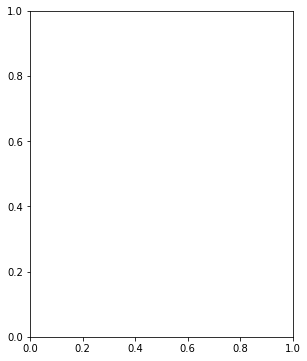

In [93]:
# plotting CV results
# for each value of c2, make a plot of c1 versus train and test f1-score

plt.figure(figsize=(16,6))

for i, val in enumerate(params_space['c2']):
   
    # subplot 1/3/i
    plt.subplot(1, 3, i+1)
    c2_subset = cv_results[cv_results['param_c2']==val]

    plt.plot(c2_subset["param_c1"], c2_subset["mean_validation_score"])
    plt.plot(c2_subset["param_c1"], c2_subset["mean_train_score"])
    plt.xlabel('c1')
    plt.ylabel('Mean F-score')
    plt.title("c2={0}".format(val))
    plt.ylim([0.80, 1])
    plt.legend(['validation score', 'train score'], loc='upper left')
    plt.xscale('log')

The plot above shows that at very low values of c_1, the model overfits, as shown by the difference in training and test performance. Also, the test score seems to be slightly higher for c_2 = 0.1.

Let's thus choose c_1 = 0.1 and c_2 = 0.1. 

In [ ]:
# building a model with optimal hyperparams
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,
    c2=0.1,
    max_iterations=100,
    all_possible_transitions=True
)
crf.fit(X_train, y_train)

Having tuned the model, we can now save (dump) it to a a pickle file so that we can simply import it and use later for predictions.

In [ ]:
# save the model to a pickle file
import _pickle as cPickle

with open('tuned_crf_classifier.pkl', 'wb') as clf:
    try:
        cPickle.dump(crf, clf)
    except Exception as e:
        print(e)
    finally:
        clf.close()   

Now let's load the dumped model from the pkl file and use it for predictions.

In [ ]:
# load the trained model
import _pickle as cPickle

with open('tuned_crf_classifier.pkl', 'rb') as fid:
    crf = cPickle.load(fid)

### Making Predictions 

Let's now use the trained model to make predictions. 

In [ ]:
# remove 'O' from the labels
labels =list(crf.classes_)


# make predictions on validation data
y_pred = crf.predict(X_valid)
metrics.flat_f1_score(y_valid, y_pred,
                      average='weighted', labels=labels)

The overall f1-score is comparable to that on training (cross-validation) data (which was about 93% on the test folds and 97% on training folds). Let's look at class-wise metrics as well.

In [ ]:
# class-wise scores on validation data
sorted_labels = sorted(
    labels,
    key=lambda name: (name[1:], name[0])
)
print(metrics.flat_classification_report(
    y_valid, y_pred, labels=sorted_labels, digits=3
))

Let's also make predictions on the test set and see the results. 

In [ ]:
# test data predictions
# make predictions on validation data
y_pred_test = crf.predict(X_test)
metrics.flat_f1_score(y_test, y_pred_test,
                      average='weighted', labels=labels)

### Understanding the CRF Classifier

Let's now understand what the classifier has learnt. The method ```crf.transition_features_``` returns a dict of key:value = (label-1, label-2):coef pairs - each key-val pair representing the transition coefficient from label-1 to label-2.

The ```Counter``` class from the collections module provides a convenient way of counting and printing the frequency of items (the top-N or bottom counts). Read the <a href="https://docs.python.org/2/library/collections.html">docs of Counter class here.</a>

In [ ]:
# look up more attributes and methods of sklearn crf
# help(crf)

In [ ]:
from collections import Counter

def print_transitions(trans_features):
    for (label_from, label_to), weight in trans_features:
        print("%-6s -> %-7s %0.6f" % (label_from, label_to, weight))

print("Top likely transitions:")
print_transitions(Counter(crf.transition_features_).most_common(20))

print("\nTop unlikely transitions:")
print_transitions(Counter(crf.transition_features_).most_common()[-20:])

The results show that the transitions ```B-fromloc.airport_name -> I-fromloc.airport_name```, ```B-depart_date.month_name -> B-depart_date.day_number``` are very likely. You can also see the unlikely transitions.

We can also see the most useful (discriminative) features.

In [ ]:
# important features
def print_state_features(state_features):
    for (attr, label), weight in state_features:
        print("%0.6f %-8s %s" % (weight, label, attr))

print("Top positive:")
print_state_features(Counter(crf.state_features_).most_common(30))

print("\nTop negative:")
print_state_features(Counter(crf.state_features_).most_common()[-30:])

Now that we have a trained tagger and have looked at the overall metrics, let's zoom in and look at the actual and predicted labels of some sample sentences.

In [ ]:
# tagging a sample sentence (first validation sentence)
i = 0
sample_sent = valid_labels[i]
print(' '.join(sent2tokens(sample_sent)), end='\n')

In [ ]:
# compare the predicted and actual labels for a query
print("Predicted:", "\n",' '.join(y_pred[0]))
print('\n')
print("Correct:", "\n" ,' '.join(sent2labels(sample_sent)))

### Converting Predicted Labels to Trees and Traversing Them

Let's now see how we can use the trained model to make predictions on unseen data and extract useful entities from it.

Once we predict the labels of a sentence, we want to extract useful entities from it. In the following code, we first append the predicted labels to the (word, pos) sentence to get tuples of (word, pos, predicted_label). Then we convert the list to tree format, as seen earlier, and traverse the tree to extract useful entities. 



In [ ]:
# function to create (word, pos_tag, predicted_iob_label) tuples for a given dataset
def append_predicted_tags(pos_tagged_data, labels):
    iob_labels = []
    for sent in list(zip(pos_tagged_data, labels)):
        pos = sent[0]
        labels = sent[1]
        l = list(zip(pos, labels))
        tuple_3 = [(word_pos[0], word_pos[1], label) for (word_pos, label) in l]
        iob_labels.append(tuple_3)
    return iob_labels

In [ ]:
# predictions of IOB tags on a sample validation sentence 
valid_tags = append_predicted_tags(valid_pos, y_pred)
valid_tags[0]

Now, we can convert the predicted sentence labels to a tree format and traverse the tree to extarct useful entities.

In [ ]:
# create a tree using the assigned iob labels
valid_trees = [conlltags2tree(sent) for sent in valid_tags]
print(valid_trees[0])

One can similarly make predictions on the test dataset and store them in tree format.

In [ ]:
# append test data predicted tags
test_tags = append_predicted_tags(test_pos, y_pred_test)
test_trees = [conlltags2tree(sent) for sent in test_tags]
print(test_trees[0])

### Traversing a Chunked Tree

Now that we have labelled the validation and test datasets, let's see how we can traverse the trees. The following code shows a sample predicted validation query and extracts all the 'chunks' from the tree.

In NLTK, trees are stored as objects of the ```Tree``` class, and each chunk of a tree is itself a subtree of the ```Tree``` class. Below, we traverse a sample tree, check whether a given object in the tree is an object  ```Tree``` (i.e. a chunk), and prints the *label* and the *leaves* of the chunk subtree.

In [ ]:
# choose a random predicted tree
i = random.randrange(len(valid_trees))

# print the string version of the chosen sentence
chunked_tree = valid_trees[i]
print(' '.join([id_to_words[val] for val in val_x[i]]), '\n')

# traverse the tree and print labels of subtrees 
for n in chunked_tree:
    if isinstance(n, nltk.tree.Tree):
        print(n.label(), n.leaves())

In [ ]:
# correctly parsed complex queries - i= 771, 410, 25, 473, 23, 498, 893, 882, 694
# ambiguous queries: not many so far
i

The sections beyond this on building an application are totally optional. 
<hr><hr><hr>

## Building an Application

Now that we can extract the chunks from any given user query, we need to decide which chunks  we actually need for our application and extract only those. 

Firstly, note that although there are a variety of labels/chunk types, only a few occur in majority of user queries. 

Secondly, while building an application to make flight reservations, you may be using an API/database to fetch the requested flight data, and the API/database may only provide certain types of information. For e.g. if the API does not provide any info about *meals* in flights, there may be no use extracting the entity ```meal_description```.

Let's look at both the variety and frequency of entities. 

In [ ]:
# list all labels of train trees
tree_labels = []
for tree in train_trees:
    for n in tree:
        if isinstance(n, nltk.tree.Tree):
            tree_labels.append(n.label())

In [ ]:
# training set has 78 unique labels
label_set = set(tree_labels)
len(label_set)

There are 78 types of labels/entities in the training set (there might be some more in validation / test as well, though not many). Let's now look at the frequency of chunk types.

In [ ]:
# frequency of chunk types/labels
# from collections import Counter
c = Counter(tree_labels)
pprint.pprint(c.most_common(10))

The dict above shows the frequency of each chunk type in the training set. As expected, the most frequent ones are ```toloc.city_name```, ```fromloc.city_name```, ```depart_date.day_name``` etc.

In the section below, we will extract some common entities from a given sentence and use <a href="https://developer.flightstats.com/">the flightstats API</a> to query flight schedules data. 

For now, we'll extract only ```fromloc.city_name```, ```toloc.city_name```, ```depart_date.day_name```, ```depart_time.period_of_day```, ```depart_date.day_number```, ```depart_date.month_name```, ```depart_time.time_relative```, ```depart_date.today_relative``` and ```depart_time.time```.

In [ ]:
# print the string version of the chosen sentence
i = random.randrange(len(valid_trees))
# i=408
chunked_tree = valid_trees[i]
print(' '.join([id_to_words[val] for val in val_x[i]]), '\n')

# acceptable labels
extract_labels = ["fromloc.city_name", "toloc.city_name", "depart_date.day_name", 
                 "depart_time.period_of_day", "depart_date.day_number", "depart_date.month_name",
                 "depart_time.time", "depart_time.time_relative", "depart_date.today_relative"]

# traverse the tree and print labels of subtrees 
for n in chunked_tree:
    if isinstance(n, nltk.tree.Tree) and \
     n.label() in extract_labels:
        print(n.label(), n.leaves())

In [ ]:
# complex queries
#i = 637, 255, 285

# funny query: i=127 (the guy just wants to get away from dallas)
i

### Querying Data from FlightStats API 

We'll use the flightstats API for getting data of flight schedules. <a href="https://developer.flightstats.com/api-docs/">The homepage of flightstats API</a> shows the list of all APIs they provide; we'll use <a href="https://developer.flightstats.com/api-docs/scheduledFlights/v1">the Schedules API</a>.

In [ ]:
# Useful flightstats URLs
# https://developer.flightstats.com/api-docs/scheduledFlights/v1
# https://developer.flightstats.com/api-docs/
# https://developer.flightstats.com/api-docs/how_to

The flightstats Schedules API provides multiple API call types (mentioned on <a href="https://developer.flightstats.com/api-docs/scheduledFlights/v1">this page</a>). Some of these are also mentioned below.

However, we'll only use the following first type of API call, ```from dep_city to arr_city on dep_date```, since it covers the majority of query types.



<img src="api.png">

The first step is to sign up and create an app ID and key. The example query below queries the Schedules API to get a list of all flights from airport_code_1 to airport_code_2 departing on a certain date (type-1 API call).

In [ ]:
# querying flightstats API 
app_id = '9bed5b33'
app_key = 'd7a448569ce9d0821da4fcc9f371e8cc'

base_url = 'https://api.flightstats.com/flex/schedules/rest/v1/json/from/'

# {departureAirportCode}/to/{arrivalAirportCode}/departing/{year}/{month}/{day}
# JFK in new york to LAX in los angeles
# make sure to enter a future date, else no data is returned
extended_url = 'JFK/to/LAX/departing/2018/7/18'

# credentials
creds = '?appId={0}&appKey={1}'.format(app_id, app_key)

# complete url
url = base_url + extended_url + creds
print(url)

In [ ]:
# request data from the API
import requests, json
data = requests.get(url).json()

In [ ]:
# sample flight details
data['scheduledFlights'][1]

In [ ]:
# number of flights returned
len(data['scheduledFlights'])

The query above uses airport codes to request the data, but our parser extracts the names of cities (san franciso, new york etc.) rather than airport codes. 

Thus, we need to convert the city names to flightstats airport codes. We can do that using another flightstats API - *airports*, which returns a list of all airports, their codes, and various other attributes.

In [ ]:
# data of all active airports
base_url = 'https://api.flightstats.com/flex/airports/rest/v1/json/active/'
url = base_url + creds
data = requests.get(url)
airports = data.json()

# convert to df
airports_df = pd.DataFrame(airports['airports'])
airports_df.to_csv('airports.csv')

In [110]:
airports_df = pd.read_csv("airports.csv")
airports_df.head()

,Unnamed: 0,active,city,cityCode,classification,countryCode,countryName,delayIndexUrl,elevationFeet,faa,...,name,postalCode,regionName,stateCode,street1,street2,timeZoneRegionName,utcOffsetHours,weatherUrl,weatherZone
0,0,True,Bay Springs,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,351,00M,...,Thigpen,NaN,North America,MS,NaN,NaN,America/Chicago,-5.0,https://api.flightstats.com/flex/weather/rest/...,NaN
1,1,True,Bridgeton,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,105,00N,...,Bucks,NaN,North America,NJ,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
2,2,True,Livingston,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,151,00R,...,Livingston Municipal,NaN,North America,TX,NaN,NaN,America/Chicago,-5.0,https://api.flightstats.com/flex/weather/rest/...,NaN
3,3,True,Mc Kenzie Bridge,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,1620,00S,...,Mc Kenzie Bridge State,NaN,North America,OR,NaN,NaN,America/Los_Angeles,-7.0,https://api.flightstats.com/flex/weather/rest/...,NaN
4,4,True,Colorado Springs,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,6874,00V,...,Meadow Lake,NaN,North America,CO,NaN,NaN,America/Denver,-6.0,https://api.flightstats.com/flex/weather/rest/...,NaN


In [111]:
# looking up 'new york' in the airports dataframe
# fs refers to 'flightstats code' of the airport
airports_df[airports_df['city'].str.lower() =='new york']

,Unnamed: 0,active,city,cityCode,classification,countryCode,countryName,delayIndexUrl,elevationFeet,faa,...,name,postalCode,regionName,stateCode,street1,street2,timeZoneRegionName,utcOffsetHours,weatherUrl,weatherZone
7526,7526,True,New York,NYC,1,US,United States,https://api.flightstats.com/flex/delayindex/re...,13,JFK,...,John F. Kennedy International Airport,11430,North America,NY,JFK Airport,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NYZ178
7637,7637,True,New York,NYC,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,NaN,...,East 60th Street Heliport,NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
8202,8202,True,New York,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,JRA,...,Port Authority-West 30Th St. Midtown. (Hel,NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
8203,8203,True,New York,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,JRB,...,Wall St (Heliport),NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
9320,9320,True,New York,NYC,1,US,United States,https://api.flightstats.com/flex/delayindex/re...,22,LGA,...,LaGuardia Airport,11371,North America,NY,Hangar 7 Center,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NYZ176
10803,10803,True,New York,NYC,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,NaN,...,Battery Park City/North Cove Sea Plane Base,NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
10858,10858,True,New York,NYC,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,NaN,...,East 34th Street - Sea Plane Base,NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
11095,11095,True,New York,NYC,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,NaN,...,Pier 11-Wall St Sea Plane Base,NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
11112,11112,True,New York,NaN,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,NaN,...,New York Skyports Seaplane Base,NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN
14332,14332,True,New York,NYC,5,US,United States,https://api.flightstats.com/flex/delayindex/re...,0,NaN,...,East 34th Street Heliport,NaN,North America,NY,NaN,NaN,America/New_York,-4.0,https://api.flightstats.com/flex/weather/rest/...,NaN


The list above shows that New York has multiple airports and thus airport codes (you can check for other cities such as LA etc.). The main airports, however, have the value classification=1 or 2. 

Let's write a small function which takes in the city name and returns the codes of the main airports.

In [614]:
# extract main airport codes from city name
def city_to_airport_code(city):
    df = airports_df[(airports_df['city'].str.lower() == city) & \
                ((airports_df['classification'] == 1) | \
                 (airports_df['classification'] == 2))]['fs']
    return list(df)


In [616]:
# samples
print(city_to_airport_code("new york"))
print(city_to_airport_code("baltimore"))
print(city_to_airport_code("chicago"))
print(city_to_airport_code("pittsburgh"))


['JFK', 'LGA']
['BWI']
['MDW', 'ORD']
['PIT']


Now, after extracting the source and destination cities (the entities ```fromloc``` and ```toloc```), we can query the API to get the list of flights. We also have to parse the dates to get the year, month and day.

### Pipeline: From Tree to Flight Data

The following pipeline shows the steps to process a given sentence tree (predicted using CRF), extract entities from it, generate a relevant API call, and apply additional constraints to filter the data.

There are roughly three layers in the application:
1. Extracting structured entities from query tree
2. Making the API call to get JSON data
3. Applying additional constraints to the retreived data 


The first layer processes the parsed tree and extracts structured entities so that we can make an API call. For e.g. queries mention dates as "seventh may" which needs to be passed to the API as integers (day=7, month=5). Similarly, a request for "flight on Wednesday" should query the API for a flight which departs on the closest upcoming Wednesday from the current data. 

The second layer's task is to make the API call and fetch the data.

The third layer applies filters on arrival/departure time, such as 'evening', 'early morning', 'after DIGIT pm' etc. to the retreived data and returns the filtered data to the user.


In [116]:
# i=776
i

776

In [618]:
## TODO:

## Layer-1: 
# get list of entities from tree
# get source and dest cities, dep date

def tree_to_dict(tree):
    # traverse the tree and store the subtrees/labels and leaves
    labels = {}
    for n in tree:
        if isinstance(n, nltk.tree.Tree) and \
        n.label() in extract_labels:
            leaf_str = ' '.join([leaf[0] for leaf in n.leaves()])
            labels[n.label()] = leaf_str
    
    return(labels)
    

Let's now convert all queries in the train, validation and test trees to corresponding dicts.

In [619]:
train_dicts = [tree_to_dict(tree) for tree in train_trees]
valid_dicts = [tree_to_dict(tree) for tree in valid_trees]
test_dicts = [tree_to_dict(tree) for tree in test_trees]

Now, let's look at some typical entries in day_number, month_name etc., so that we can process them correctly. For example, how are day and months typically written - *seventh, twenty third, September (or Sept?)* etc. 

In [620]:
# depart_date.day_name
day_names = [d.get("depart_date.day_name") for d in train_dicts \
            if d.get("depart_date.day_name") is not None]
print("day_names\n", set(day_names), '\n')

# depart_date.day_number
day_numbers = [d.get("depart_date.day_number") for d in train_dicts 
               if d.get("depart_date.day_number") is not None]
print("day_numbers\n", set(day_numbers), '\n')


# depart_date.month_name
month_names = [d.get("depart_date.month_name") for d in train_dicts 
               if d.get("depart_date.month_name") is not None]
print("month_name\n", set(month_names), '\n')

# depart_time.time_relative
time_relative = [d.get("depart_time.time_relative") for d in train_dicts 
               if d.get("depart_time.time_relative") is not None]
print("time_relative\n", set(time_relative), '\n')

# depart_time.time
time = [d.get("depart_time.time") for d in train_dicts 
               if d.get("depart_time.time") is not None]
print("time\n", set(time), '\n')

# depart_time.period_of_day
period_of_day = [d.get("depart_time.period_of_day") for d in train_dicts 
               if d.get("depart_time.period_of_day") is not None]
print("period_of_day\n", set(period_of_day), '\n')

# depart_date.today_relative
today_relative = [d.get("depart_date.today_relative") for d in train_dicts 
               if d.get("depart_date.today_relative") is not None]
print("today_relative\n", set(today_relative), '\n')


day_names
 {'thursdays', 'monday', 'sundays', 'saturday', 'wednesday', '<UNK>', 'weekday', 'saturdays', 'thursday', 'sunday', 'wednesdays', 'friday', 'tuesdays', 'tuesday'} 

day_numbers
 {'third', 'eighth', 'eighteenth', 'twenty seventh', 'six', 'eight', 'thirtieth', 'sixteenth', 'twenty fifth', 'seventeenth', 'twelfth', 'second', 'tenth', 'fourteenth', 'first', 'nineteenth', 'one', '<UNK>', 'twenty ninth', 'fifteenth', 'sixth', 'twenty eighth', 'twentieth', 'three', 'seventh', 'thirty first', 'twenty two', 'eleventh', 'sixteen', 'four', 'ninth', 'fifth', 'twenty fourth', 'twenty second', 'twenty third', 'twenty six', 'twenty sixth', 'thirteenth', 'twenty first', 'twenty one', 'fourth', 'twenty'} 

month_name
 {'april', 'november', 'august', 'february', 'september', 'july', 'may', 'june', 'january', 'december', 'october', 'march'} 

time_relative
 {'later', 'about', 'earlier', 'approximately', 'after', 'no later than', 'by', '<UNK>', 'before', 'around'} 

time
 {'DIGITDIGIT noon', 'DI

Dealing with months is the easiest since there are just 12 varieties. Similarly, day names cab be looked up from a manully created dict ```{sunday, sundays, tuesday, tuesdays, ...}``` etc.

For converting day numbers to numerics, although there are some nice third-party libraries such as ```word2num```, they only handle simple cases such as 'one', 'thirty two' etc. but not words which ends in suffixes such as 'twentieth', 'thirty first' etc.

Credits: <a href="https://stackoverflow.com/questions/493174/is-there-a-way-to-convert-number-words-to-integers?utm_medium=organic&utm_source=google_rich_qa&utm_campaign=google_rich_qa">Stack Overflow</a>

In [621]:
# text2int
def text2int(textnum, numwords={}):
    if not numwords:
        units = [
        "zero", "one", "two", "three", "four", "five", "six", "seven", "eight",
        "nine", "ten", "eleven", "twelve", "thirteen", "fourteen", "fifteen",
        "sixteen", "seventeen", "eighteen", "nineteen",
        ]

        tens = ["", "", "twenty", "thirty", "forty", "fifty", "sixty", "seventy", "eighty", "ninety"]

        scales = ["hundred", "thousand", "million", "billion", "trillion"]

        numwords["and"] = (1, 0)
        for idx, word in enumerate(units):  numwords[word] = (1, idx)
        for idx, word in enumerate(tens):       numwords[word] = (1, idx * 10)
        for idx, word in enumerate(scales): numwords[word] = (10 ** (idx * 3 or 2), 0)

    ordinal_words = {'first':1, 'second':2, 'third':3, 'fifth':5, 'eighth':8, 'ninth':9, 'twelfth':12}
    ordinal_endings = [('ieth', 'y'), ('th', '')]

    textnum = textnum.replace('-', ' ')

    current = result = 0
    for word in textnum.split():
        if word in ordinal_words:
            scale, increment = (1, ordinal_words[word])
        else:
            for ending, replacement in ordinal_endings:
                if word.endswith(ending):
                    word = "%s%s" % (word[:-len(ending)], replacement)

            if word not in numwords:
                raise Exception("Illegal word: " + word)

            scale, increment = numwords[word]
        current = current * scale + increment
        if scale > 100:
            result += current
            current = 0

    return result + current

In [622]:
# examples
print(text2int("twenty"))
print(text2int("first"))
print(text2int("thirtieth"))
print(text2int("twenty eighth"))
print(text2int("twelfth"))

20
1
30
28
12


In [623]:
# months: use the builtin calendar module
import calendar 
month2int = {v.lower():k for k,v in enumerate(calendar.month_name)}
month2int    

{'': 0,
 'january': 1,
 'february': 2,
 'march': 3,
 'april': 4,
 'may': 5,
 'june': 6,
 'july': 7,
 'august': 8,
 'september': 9,
 'october': 10,
 'november': 11,
 'december': 12}

In [486]:
# days
day2int = {v.lower():k for k,v in enumerate(calendar.day_name)}
day2int

{'monday': 0,
 'tuesday': 1,
 'wednesday': 2,
 'thursday': 3,
 'friday': 4,
 'saturday': 5,
 'sunday': 6}

Now, when coming across a day name such as Monday, Tuesday etc. we'll simply use the date corresponding to the next Monday/Tuesday. The following code returns the date of the next day_name.

In [492]:
# return the date of the next day_name from today
import datetime
def next_weekday(d, weekday):
    days_ahead = weekday - d.weekday()
    if days_ahead <= 0: # Target day already happened this week
        days_ahead += 7
    return d + datetime.timedelta(days_ahead)

today = datetime.date.today()
next_day = next_weekday(today, 1) # 0 = Monday, 1=Tuesday, 2=Wednesday...
print("date", next_day)
print("year", next_day.year)
print("month", next_day.month)
print("day", next_day.day)


date 2018-05-15
year 2018
month 5
day 15


Now we can extract entities in numeric format using these functions/dicts. Given a query (tree), we'll extract source and destination cities, day (int), month (int) etc. If the day is specified as name e.g. Monday, we'll assume it is the next Monday and query that date. 

For time and time modifiers such as before, after etc., we'll filter the 'arr/dep time' attributes after we get the data from the API.

In [631]:
# extract integer dates etc from query tree
def extract_entities_from_tree(tree):
    query_dict = tree_to_dict(tree)
    entities = {}
    
    for key, val in query_dict.items():
        
        # get airport codes from city names as a list
        if key == "fromloc.city_name" or key == "toloc.city_name":
            entities[key] = city_to_airport_code(val)
            
        # strip the last 's' e.g. tuesdays from day of week
        if key == "depart_date.day_name":
            query_dict[key] = val[:-1] if val.endswith("s") else val
            
            # get year, month, day of the next day_name
            day_num = day2int[query_dict[key]]
            today = datetime.date.today()
            next_day = next_weekday(today, day_num) # 0 = Monday, 1=Tuesday, 2=Wednesday...
            entities['day'] = next_day.day
            entities['month'] = next_day.month
            entities['year'] = next_day.year

        # day number explicitly mentioned
        if key == "depart_date.day_number":
            entities['day'] = text2int(val)
            today = datetime.date.today()
            entities['month'] = today.month
            entities['year'] = today.year
            
        # month explicitly mentioned
        if key == "depart_date.month_name":
            entities['month'] = month2int[val]
            # assume today's date and year
            today = datetime.date.today()
            entities['day'] = today.day
            entities['year'] = today.year
        
        # if day/month/year still not in dict, show tomorrow's flights
        if ('day' not in entities.keys() or 
            'month' not in entities.keys() or 
            'year' not in entities.keys()):
            today = datetime.date.today()
            tom = today + datetime.timedelta(days=1)
            entities['day'] = tom.day
            entities['month'] = tom.month
            entities['year'] = tom.year 
        
    return query_dict, entities
    
    

In [642]:
i = random.randrange(len(train_trees))
i=2308
print(' '.join([id_to_words[t] for t in train_x[i]]), '\n')
q, d = extract_entities_from_tree(train_trees[i])
print(train_trees[i])
print(q)
print(d)

list the flights arriving in baltimore from boston before DIGITDIGIT am on august third 

(S
  list/NN
  the/DT
  flights/NNS
  arriving/VBG
  in/IN
  (toloc.city_name baltimore/NN)
  from/IN
  (fromloc.city_name boston/NN)
  (arrive_time.time_relative before/IN)
  (arrive_time.time DIGITDIGIT/NNP am/VBP)
  on/IN
  (arrive_date.month_name august/JJ)
  (arrive_date.day_number third/NN))
{'toloc.city_name': 'baltimore', 'fromloc.city_name': 'boston'}
{'toloc.city_name': ['BWI'], 'day': 15, 'month': 5, 'year': 2018, 'fromloc.city_name': ['BOS']}


In [639]:
# examples from train set
# i=1285, 2438 , 3442, 3120, 1956, 2084
i

2308

 ### Ignore - Processing a Sample User Generated Query

In [400]:
# sample: predicting a new user generated query
s = 'Can you please show me flights from new york to los angeles departing on monday after DIGIT pm'

# tokenize and tag user query and create features for each token
def process_user_query(sent_string):
    tokens = nltk.word_tokenize(sent_string)
    pos_tags = nltk.pos_tag(tokens)# Viterbi Heuristic, HMM
    
    # create features from words in query q
    query_features = [word_features(pos_tags, i) for i in range(len(pos_tags))]      
    return(pos_tags, query_features)

# generate query features for sentence s
query_pos_tags, query_features = process_user_query(s)

# predict tags of query
predicted_labels = crf.predict([query_features])[0] 
predicted_labels

['O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'O',
 'B-fromloc.city_name',
 'I-fromloc.city_name',
 'O',
 'B-toloc.city_name',
 'I-toloc.city_name',
 'O',
 'O',
 'B-depart_date.day_name',
 'B-depart_time.time_relative',
 'B-depart_time.time',
 'I-depart_time.time']

In [401]:
# convert the predicted labels into standard (token, pos, label) format
query_tag_list = [(pos_tag[0], pos_tag[1], label) for pos_tag, label in list(zip(query_pos_tags, predicted_labels))]

# convert into tree
query_tree = conlltags2tree(query_tag_list)

# traverse the tree and print labels of subtrees 
for n in query_tree:
    if isinstance(n, nltk.tree.Tree):
        label = n.label()
        leaves = ' '.join(i[0] for i in n.leaves())
        print(label,':', leaves)

fromloc.city_name : new york
toloc.city_name : los angeles
depart_date.day_name : monday
depart_time.time_relative : after
depart_time.time : DIGIT pm


#### Input

s = 'Can you please show me flights from new york to los angeles departing on monday after DIGIT pm'

#### Output

fromloc.city_name : new york

toloc.city_name : los angeles

depart_date.day_name : monday

depart_time.time_relative : after

depart_time.time : DIGIT pm